Q1) Dataset contains Monthly and Daily prices of Natural gas, starting from January 1997 to current year. Prices are in nominal dollars. The task is to predict the price of natural gas using RNN model for the dataset
https://datahub.io/core/natural-gas#resource-daily 
https://www.kaggle.com/datasets/joebeachcapital/natural-gas-prices

Given the price of last ten 10 days, corresponds to sequence_length, the RNN model must predict the price for the 11th day

Epoch 0 Loss: 0.0002
Epoch 10 Loss: 0.0000


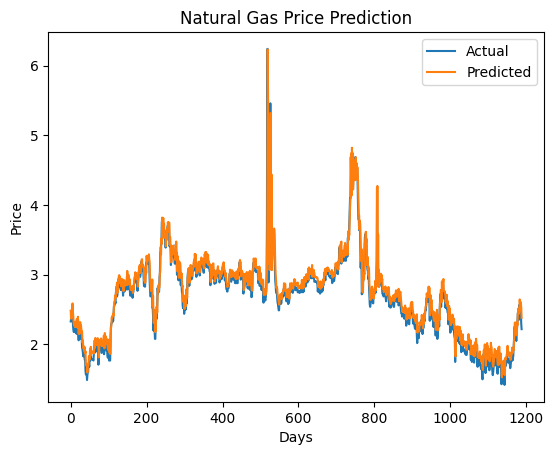


🧠 Predicted price for the 11th day: $2.3318


In [11]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and normalize data
df = pd.read_csv("/home/mustafa/dllab/w8prac/q1/daily_csv.csv")
df = df.dropna()
prices = df['Price'].values.reshape(-1, 1)

scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(prices)

# Prepare sequences
sequence_length = 10
X, Y = [], []
for i in range(len(prices_scaled) - sequence_length):
    X.append(prices_scaled[i:i + sequence_length])
    Y.append(prices_scaled[i + sequence_length])

X = np.array(X)
Y = np.array(Y)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False)

# Custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# Dataloaders
train_loader = DataLoader(TimeSeriesDataset(x_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(x_test, y_test), batch_size=1)

# RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

model = RNNModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    for xb, yb in train_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} Loss: {loss.item():.4f}")

# Testing
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        predictions.append(pred.item())
        actuals.append(yb.item())

# Inverse scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot results
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Natural Gas Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

# Take last 10 actual values from the full (normalized) dataset
last_10_days = torch.tensor(prices_scaled[-10:], dtype=torch.float32).view(1, 10, 1)

# Predict the 11th day price
model.eval()
with torch.no_grad():
    next_day_pred = model(last_10_days).item()

# Inverse transform to get the original price scale
next_day_price = scaler.inverse_transform([[next_day_pred]])
print(f"\n🧠 Predicted price for the 11th day: ${next_day_price[0][0]:.4f}")


Q2) The data provided at the link https://download.pytorch.org/tutorial/data.zip consists of
names stored in the format {language: [names ...]} i.e. each language contains a list of
names. Train a RNN on a few thousand surnames from 18 languages of origin, and
predict which language a name is from based on the spelling.

In [1]:
import os
import glob
import torch
import string
import random
import numpy as np

ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for i, letter in enumerate(name):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

def read_names(filename):
    with open(filename, encoding='utf-8') as f:
        return [line.strip() for line in f.readlines()]

language_names = {}
for filepath in glob.glob("data/names/*.txt"):
    language = os.path.splitext(os.path.basename(filepath))[0]
    language_names[language] = read_names(filepath)

languages = list(language_names.keys())
N_LANGUAGES = len(languages)

def random_training_example():
    language = random.choice(languages)
    name = random.choice(language_names[language])
    name_tensor = name_to_tensor(name)
    lang_index = languages.index(language)
    lang_tensor = torch.tensor(lang_index, dtype=torch.long)
    return name_tensor, name, lang_tensor, language

train_data = [random_training_example() for _ in range(10000)]  # You can load more

class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # out: (batch, seq_len, hidden)
        out = out[:, -1, :]   # Take last timestep
        return self.fc(out)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNModel(N_LETTERS, hidden_size=128, output_size=N_LANGUAGES).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    random.shuffle(train_data)
    batches = [train_data[i:i+64] for i in range(0, len(train_data), 64)]
    total_loss = 0.0

    for batch in batches:
        names, labels = [], []
        max_len = max([x[0].size(0) for x in batch])
        padded = torch.zeros(len(batch), max_len, N_LETTERS)

        for i, (tensor, _, label_tensor, _) in enumerate(batch):
            padded[i, :tensor.size(0), :] = tensor.squeeze(1)
            labels.append(label_tensor)

        inputs = padded.to(device)
        targets = torch.tensor(labels, dtype=torch.long).to(device)

        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch} | Loss: {total_loss:.4f}")
def predict(name):
    model.eval()
    with torch.no_grad():
        name_tensor = name_to_tensor(name).squeeze(1).unsqueeze(0).to(device)
        output = model(name_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
        return languages[predicted_index]

print(predict("Schmidt"))   # Example: German
print(predict("Yamamoto"))  # Japanese
print(predict("Kumar"))     # Indian
print(predict("Garcia"))    # Spanish


Epoch 0 | Loss: 2.9977
Epoch 5000 | Loss: 2.6870
Epoch 10000 | Loss: 2.9990
Epoch 15000 | Loss: 0.8102
Epoch 20000 | Loss: 2.4099
Epoch 25000 | Loss: 0.6089
Epoch 30000 | Loss: 0.5279
Epoch 35000 | Loss: 0.9075
Epoch 40000 | Loss: 0.9419
Epoch 45000 | Loss: 1.8942
Epoch 50000 | Loss: 1.4134
Epoch 55000 | Loss: 0.3697
Epoch 60000 | Loss: 1.5699
Epoch 65000 | Loss: 0.2543
Epoch 70000 | Loss: 1.0591
Epoch 75000 | Loss: 2.2055
Epoch 80000 | Loss: 3.9630
Epoch 85000 | Loss: 0.6933
Epoch 90000 | Loss: 0.0464
Epoch 95000 | Loss: 0.2676
English
Japanese
Czech
Portuguese


3. Implement a next character predictor using RNN Model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

text = "teri mummy meri"

chars = list(set(text))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for ch, i in char_to_idx.items()}
text_indices = [char_to_idx[ch] for ch in text]

sequence_length = 3
hidden_size = 128
num_epochs = 500
lr = 0.01

X_train = []
Y_train = []
for i in range(len(text_indices) - sequence_length):
    X_train.append(text_indices[i:i+sequence_length])
    Y_train.append(text_indices[i+sequence_length])

X_train = torch.tensor(X_train, dtype=torch.long)
Y_train = torch.tensor(Y_train, dtype=torch.long)

class CharRNN(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(CharRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.rnn(x)  # No manual hidden
        out = self.fc(out[:, -1, :])
        return out

model = CharRNN(len(chars), hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

def predict_next(model, input_text):
    model.eval()
    input_indices = [char_to_idx[ch] for ch in input_text]
    input_tensor = torch.tensor([input_indices], dtype=torch.long)

    with torch.no_grad():
        output = model(input_tensor)
        predicted_idx = torch.argmax(output, dim=1).item()

    return idx_to_char[predicted_idx]

input_text = "mmy"
predicted_char = predict_next(model, input_text)
print(f"Next character after '{input_text}': {predicted_char}")


Epoch [50/500], Loss: 0.0001
Epoch [100/500], Loss: 0.0001
Epoch [150/500], Loss: 0.0000
Epoch [200/500], Loss: 0.0000
Epoch [250/500], Loss: 0.0000
Epoch [300/500], Loss: 0.0000
Epoch [350/500], Loss: 0.0000
Epoch [400/500], Loss: 0.0000
Epoch [450/500], Loss: 0.0000
Epoch [500/500], Loss: 0.0000
Next character after 'mmy':  


 complete RNN time series task using a Sawtooth wave,

Epoch 0, Loss: 0.0008
Epoch 5, Loss: 0.0008
Epoch 10, Loss: 0.0014
Epoch 15, Loss: 0.0015
Epoch 20, Loss: 0.0026
Epoch 25, Loss: 0.0001


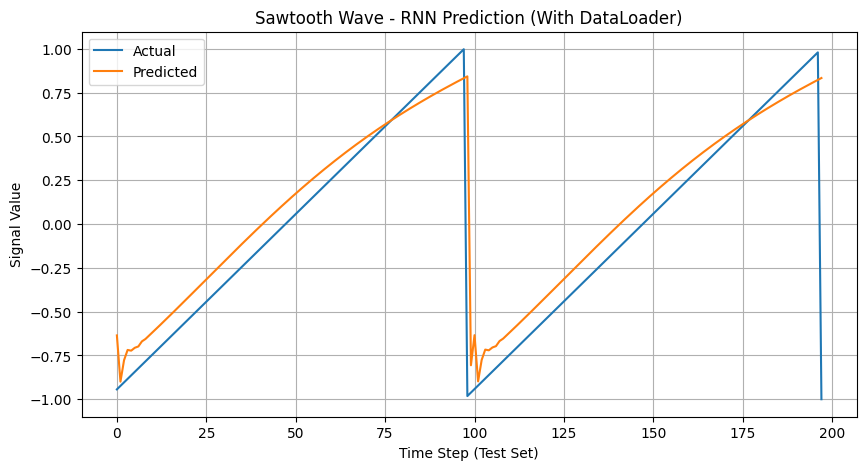

In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import sawtooth
import matplotlib.pyplot as plt

# Generate a clean sawtooth wave
x = np.linspace(0, 20 * np.pi, 1000)
signal = sawtooth(x, width=1)

# Normalize
scaler = MinMaxScaler()
signal_scaled = scaler.fit_transform(signal.reshape(-1, 1))

# Prepare sequences
sequence_length = 10
X, Y = [], []
for i in range(len(signal_scaled) - sequence_length):
    X.append(signal_scaled[i:i + sequence_length])
    Y.append(signal_scaled[i + sequence_length])

X = np.array(X)
Y = np.array(Y)

# Train-test split
split = int(0.8 * len(X))
x_train, x_test = X[:split], X[split:]
y_train, y_test = Y[:split], Y[split:]

# Custom dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

# Dataloaders
train_loader = DataLoader(TimeSeriesDataset(x_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(x_test, y_test), batch_size=1)

# RNN model
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

model = RNNModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(30):
    model.train()
    for xb, yb in train_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Prediction
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        predictions.append(pred.item())
        actuals.append(yb.item())

# Inverse scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("Sawtooth Wave - RNN Prediction (With DataLoader)")
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Signal Value")
plt.legend()
plt.grid(True)
plt.show()


You are given a noisy sine wave signal. Use an RNN model to predict the next value given a sequence of the previous 20 values. Plot the actual and predicted values for the test set.

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [25]:
x = np.linspace(0, 100, 1000)
signal = np.sin(x) + 0.1 * np.random.randn(1000)

In [27]:
scaler=MinMaxScaler()
signal_scaled=scaler.fit_transform(signal.reshape(-1,1))
sequence_length=20
X,Y=[],[]
for i in range(len(signal_scaled)-sequence_length):
    X.append(signal_scaled[i:i+sequence_length])
    Y.append(signal_scaled[i+sequence_length])

X=np.array(X, dtype=np.float32)
Y=np.array(Y, dtype=np.float32)




In [33]:
class TimeSeriesDataset(Dataset):
    def __init__(self,x,y):
        self.x=torch.tensor(x)
        self.y=torch.tensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [34]:
split=int(0.8*len(X))
train_loader = DataLoader(TimeSeriesDataset(X[:split], Y[:split]), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(X[split:], Y[split:]), batch_size=1)


In [44]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn=nn.LSTM(input_size=1,hidden_size=64,batch_first=True)
        self.fc=nn.Linear(64,1)
    def forward(self,x):
        out,_=self.rnn(x)
        return self.fc(out[:,-1,:])

In [45]:
model=RNNModel()
loss_fc=nn.MSELoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

In [46]:
for epoch in range(100):
    for xb,yb in train_loader:
        xb=xb.view(-1,sequence_length,1)
        pred=model(xb)
        loss=loss_fc(pred,yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch%5==0:
        print(f"epoch{epoch}, Loss:{loss.item():.4f}")


epoch0, Loss:0.0497
epoch5, Loss:0.0031
epoch10, Loss:0.0011
epoch15, Loss:0.0019
epoch20, Loss:0.0015
epoch25, Loss:0.0013
epoch30, Loss:0.0023
epoch35, Loss:0.0016
epoch40, Loss:0.0021
epoch45, Loss:0.0024
epoch50, Loss:0.0013
epoch55, Loss:0.0023
epoch60, Loss:0.0016
epoch65, Loss:0.0021
epoch70, Loss:0.0020
epoch75, Loss:0.0031
epoch80, Loss:0.0021
epoch85, Loss:0.0034
epoch90, Loss:0.0022
epoch95, Loss:0.0011


In [47]:
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.view(-1, sequence_length, 1)
        pred = model(xb)
        predictions.append(pred.item())
        actuals.append(yb.item())

In [48]:
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

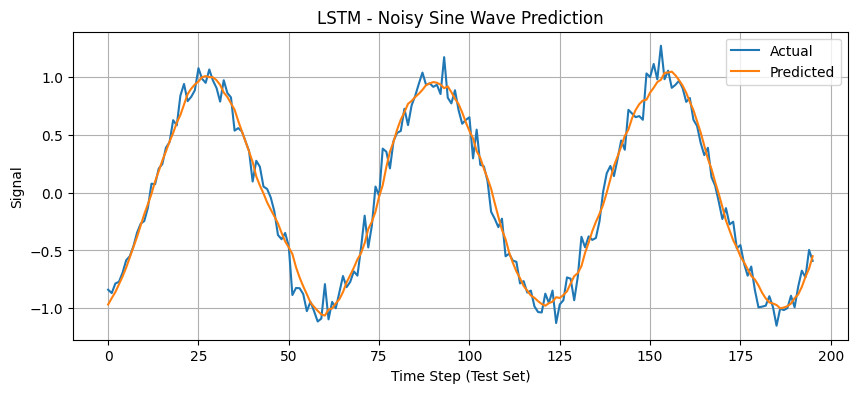

In [49]:
plt.figure(figsize=(10, 4))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title("LSTM - Noisy Sine Wave Prediction")
plt.xlabel("Time Step (Test Set)")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()